<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE2-VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RUNNING SMART PIPELINE (RECOMMENDED)
STARTING SMART VAE PIPELINE
Loading VAE models with custom layers...
VAE models loaded successfully!
✅ VAE models loaded successfully!
✅ Synthetic data already exists! Loading...
   Loaded 350000 synthetic samples
✅ VAR windows already computed! Loading...
   Loaded 350000 VAR windows
   Loaded 350000 final synthetic samples
✅ SMART PIPELINE COMPLETE!
   Synthetic samples: 350000
   VAR windows: 350000
   🚀 All work completed - no computation needed!

📊 AUTOMATIC VAE PERFORMANCE EVALUATION
Running quick VAE performance check...
✅ VAE Performance Check:
   MSE: 0.014233
   MAE: 0.058696
   Input shape: (10, 50, 13)
   Output shape: (10, 50, 13)
✅ Good reconstruction quality!

🎨 Generating reconstruction visualizations...
EVALUATING VAE RECONSTRUCTION PERFORMANCE
Testing reconstruction on 3 samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
Sample 1: MSE = 0.008396, MAE = 0.053566
Sample 2: MSE = 0.007725, MAE = 0

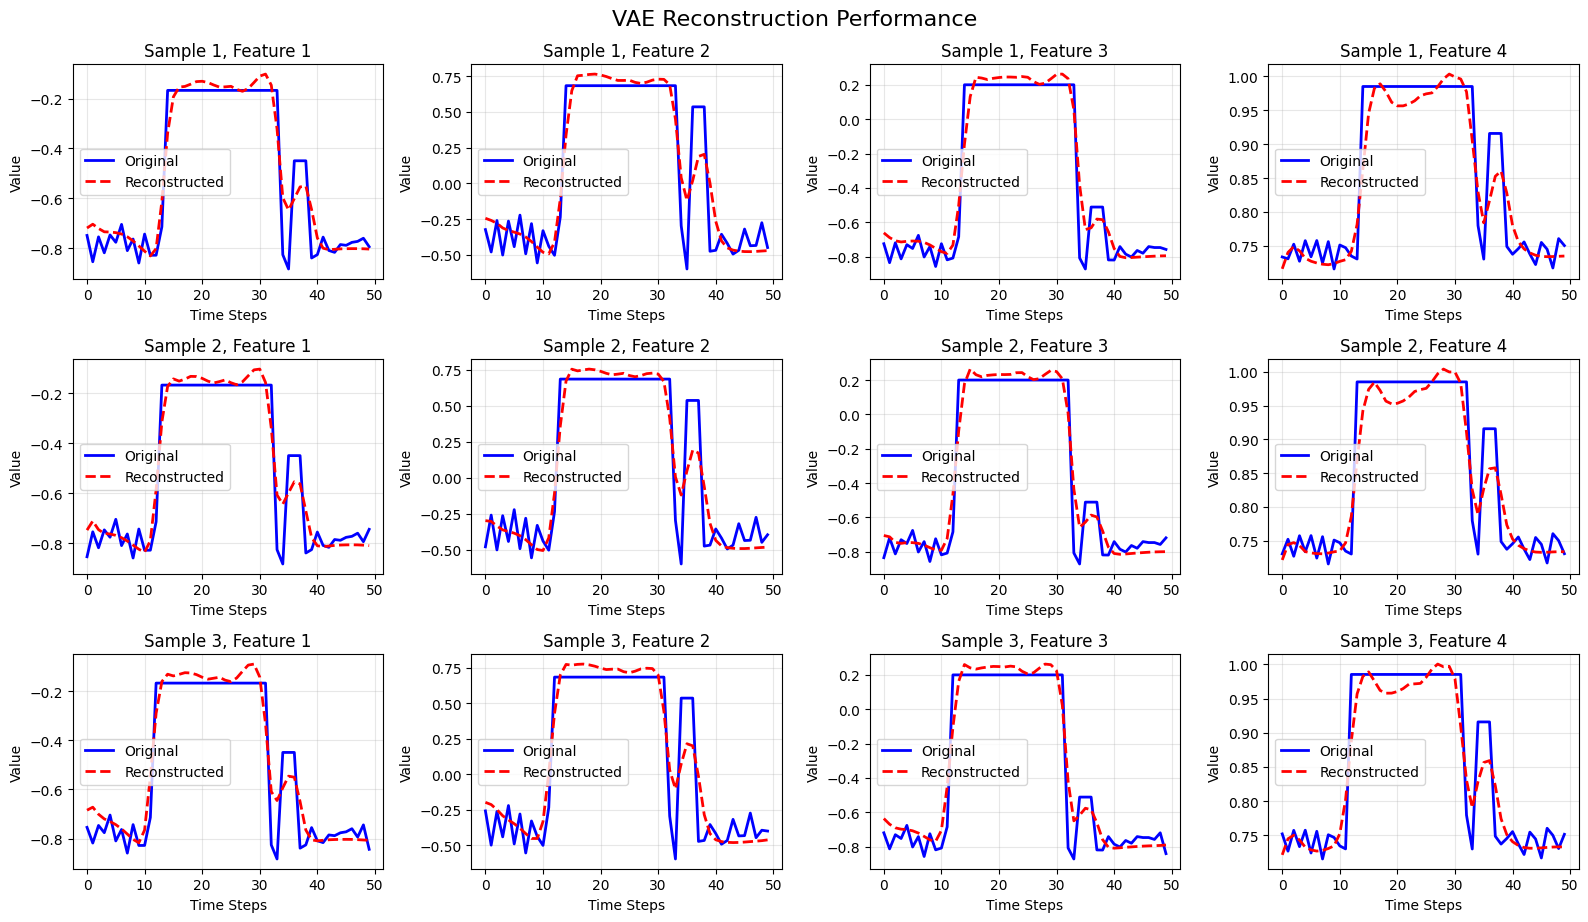

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


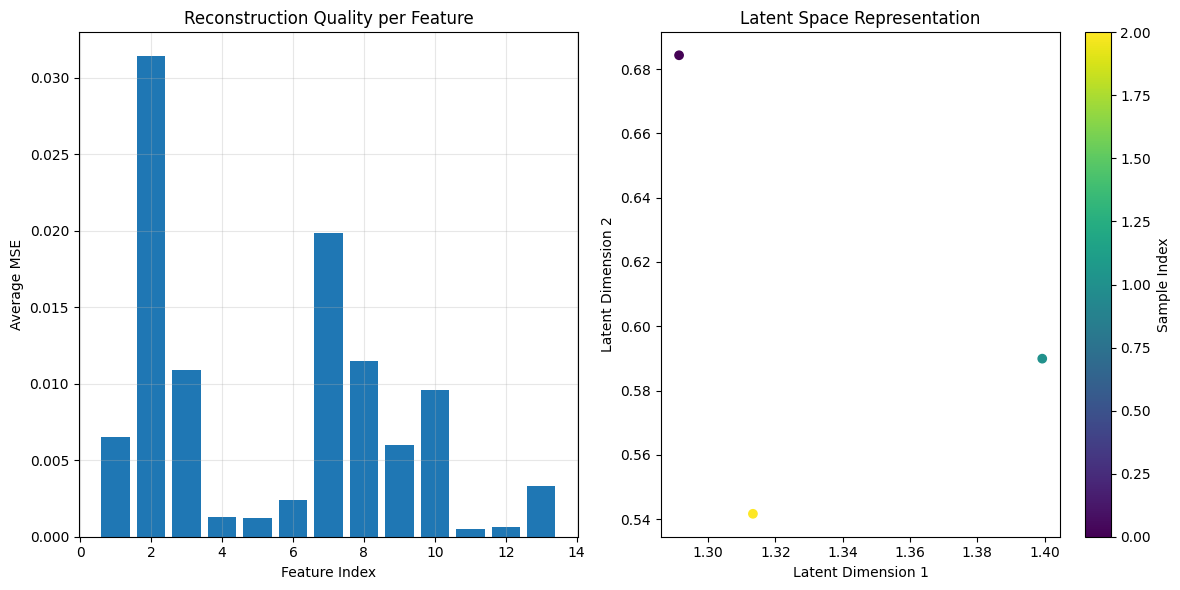


Feature Reconstruction Quality (MSE):
Feature 1: 0.006533
Feature 2: 0.031394
Feature 3: 0.010894
Feature 4: 0.001257
Feature 5: 0.001216
Feature 6: 0.002403
Feature 7: 0.019873
Feature 8: 0.011463
Feature 9: 0.006021
Feature 10: 0.009593
Feature 11: 0.000536
Feature 12: 0.000646
Feature 13: 0.003329
✅ Visualization complete!

EVALUATING VAE PERFORMANCE
Running quick VAE performance check...
✅ VAE Performance Check:
   MSE: 0.014894
   MAE: 0.058891
   Input shape: (10, 50, 13)
   Output shape: (10, 50, 13)
✅ Good reconstruction quality!

🎉 PIPELINE COMPLETE!
   Synthetic data shape: (350000, 650)
   VAR windows shape: (350000,)


"\n# Just copy and paste this for immediate use:\n\ngenerator = VAEDataGenerator()\nresults = generator.run_smart_pipeline(\n    r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-AUTO.npy',\n    target_samples=350000\n)\n\n# Check performance\ngenerator.quick_vae_check(\n    r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-AUTO.npy'\n)\n"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
import keras
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import saving
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import Callback
import plotly
from keras import losses
import plotly.express as px

# Load data
train_data = np.load(r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy')
window_label = np.load(r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences_WINDOW-Daily-DIRECT-VAR.npy')

n_seq = train_data.shape[0]
window_size = train_data.shape[1]
n_features = train_data.shape[2]

maxval = train_data.shape[0]
count_train = int(math.ceil(0.8*maxval))
x_train = train_data[:count_train]
x_test = train_data[count_train:]

# Clear all previously registered custom objects
saving.get_custom_objects().clear()

# Create a custom layer
@saving.register_keras_serializable(package="MyLayers")
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return {"factor": self.factor}

# Build the encoder
latent_dim = 5
intermediate_dim = 256

# Encoder
encoder_inputs = layers.Input(shape=(window_size, n_features), name="encoder_input")
x = layers.LSTM(intermediate_dim, activation='tanh', name="lstm1", return_sequences=True)(encoder_inputs)
xx = layers.LSTM(int(intermediate_dim/2), activation='tanh', name="lstm2", return_sequences=False)(x)
x1 = layers.Dense(int(intermediate_dim/2), name="dense")(xx)
z_mean = layers.Dense(latent_dim, name="z_mean")(x1)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x1)
z = Sampling(1)([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
inp_z = Input(shape=(latent_dim,), name="decoder")
x1 = layers.RepeatVector(window_size, name="repeatvect")(inp_z)
x2 = layers.Dense(int(intermediate_dim/2), name="Dense2")(x1)
x22 = layers.LSTM(int(intermediate_dim/2), activation='tanh', return_sequences=True, name="lstm1")(x2)
x3 = layers.LSTM(intermediate_dim, activation='tanh', return_sequences=True, name="lstm2")(x22)
decode_out = layers.TimeDistributed(Dense(n_features), name="decodeout")(x3)
decoder = keras.Model(inp_z, decode_out, name="decoder")
decoder.summary()

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

# Parameters
n_epochs = 150
klstart = 20
kl_annealtime = n_epochs - klstart
weight = K.variable(0.0)

# Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.mean_squared_error(data, reconstruction), axis=-1), keepdims=True
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + (weight * kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                losses.mean_squared_error(data, reconstruction), axis=-1), keepdims=True
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# CALLBACKS
es = keras.callbacks.EarlyStopping(patience=50, verbose=1, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)

class AnnealingCallback(Callback):
    def __init__(self, weight):
        self.weight = weight

    def on_epoch_end(self, epoch, logs={}):
        if epoch > klstart and epoch < klstart * 1.2:
            new_weight = min(K.get_value(self.weight) + (1. / kl_annealtime), 1.)
            K.set_value(self.weight, new_weight)
        print("Current KL Weight is " + str(K.get_value(self.weight)))

# Train the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(clipnorm=1))
history = vae.fit(x_train,
                  epochs=n_epochs,
                  batch_size=32,
                  validation_split=0.1,
                  callbacks=[AnnealingCallback(weight)])

# Save models
encoder.save(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/METROPM_vae-encoder-latent5-dim256.keras')
decoder.save(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/METROPM_vae-decoder-latent5-dim256.keras')

# Reload models
encoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/METROPM_vae-encoder-latent5-dim256.keras')
decoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/METROPM_vae-decoder-latent5-dim256.keras')

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['reconstruction_loss'], label='reconstruction_loss')
plt.plot(history.history['kl_loss'], label='kl_Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()

# Just Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# PLOT TRAIN RECONSTRUCTION
X_test_encoded = encoder.predict(x_train)
X_test_predict = decoder(X_test_encoded[2])
plt.suptitle('Example Reconstruction of Training Data')
plt.xlabel('Time', fontsize='10')
plt.ylabel('Feature 6', fontsize='10')
plt.plot(x_train[:, :, 5], "r", label="Actual")
plt.plot(X_test_predict[:, :, 5], "b", label="reconstructed")
plt.show()

# PLOT TEST RECONSTRUCTION
X_test_encoded = encoder.predict(x_test[:, :, :])
X_test_predict = decoder(X_test_encoded[2])
plt.suptitle('Example Reconstruction of Testing Data')
plt.xlabel('Time', fontsize='10')
plt.ylabel('Feature 6', fontsize='10')
plt.plot(x_test[:, :, 5], "r")
plt.plot(X_test_predict[:, :, 5], "b")
plt.show()

fig = px.scatter(None, x=X_test_encoded[2][:, 0], y=X_test_encoded[2][:, 1], opacity=1, color=window_label.astype(str))
fig.update_layout(dict(plot_bgcolor='white'))
fig.update_traces(marker=dict(size=2))
fig.show()

# Generate data for MLP
generator_multiply = 100

X_train_encoded = encoder.predict(train_data)
mu, logvar, z = X_train_encoded
sigma = tf.exp(0.5 * logvar)
batch = tf.shape(mu)[0]
dim = tf.shape(mu)[1]
store = list()

for i in range(0, batch):
    all_Z_i = tf.random.normal(shape=(generator_multiply, dim), mean=mu[i, :], stddev=sigma[i, :])
    X_train_decoded = decoder.predict(all_Z_i)
    X_train_decoded = X_train_decoded.reshape((X_train_decoded.shape[0], window_size * n_features))
    store.append(X_train_decoded)

results1 = np.concatenate(store, axis=0)
np.save(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_METROPM/generated_large_subsquence2_data.npy', results1)

# Generate window labels using VAR analysis
x = results1
x_3d = x.reshape((x.shape[0], window_size, n_features))
n_future = 1
K = window_size

from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

best_window_for_long_seq = list()

# Process data in cohorts (adjust ranges as needed)
cohort_start = 0
cohort_end = min(50000, x.shape[0])  # Adjust based on your needs

for i in range(cohort_start, cohort_end):
    rmse_list = []
    for k in range(2, round(K)):
        cur_seq = x_3d[i, :, :]
        df = pd.DataFrame(cur_seq, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'])
        df_train, df_test = df[0:-n_future], df[-n_future:]
        model = VAR(df_train)
        try:
            model_fitted1 = model.fit(k)
            forecast_input1 = df_train.values[-k:]
            fc1 = model_fitted1.forecast(y=forecast_input1, steps=n_future)
            df_forecast1 = pd.DataFrame(fc1, index=df.index[-n_future:], columns=df.columns)
            mse = mean_squared_error(df_test['V1'], df_forecast1['V1'].values)
            rmse_list.append(mse)
        except:
            rmse_list.append(99999)
            print('VAR could not solve row number', i, k)

    min_index = rmse_list.index(min(rmse_list))
    min_sw = min_index + 2
    print('i=', i, 'SW =', min_sw, rmse_list)
    best_window_for_long_seq.append(min_sw)

Window = np.array(best_window_for_long_seq)
y = Window

# Save generated data and labels for MLP
np.save(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_METROPM/generated-data-true-window2.npy', y)
np.save(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_METROPM/generated-data2.npy', x[:len(y)])

print("VAE training complete. Generated data and window labels saved.")
print(f"Generated data shape: {x[:len(y)].shape}")
print(f"Window labels shape: {y.shape}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')